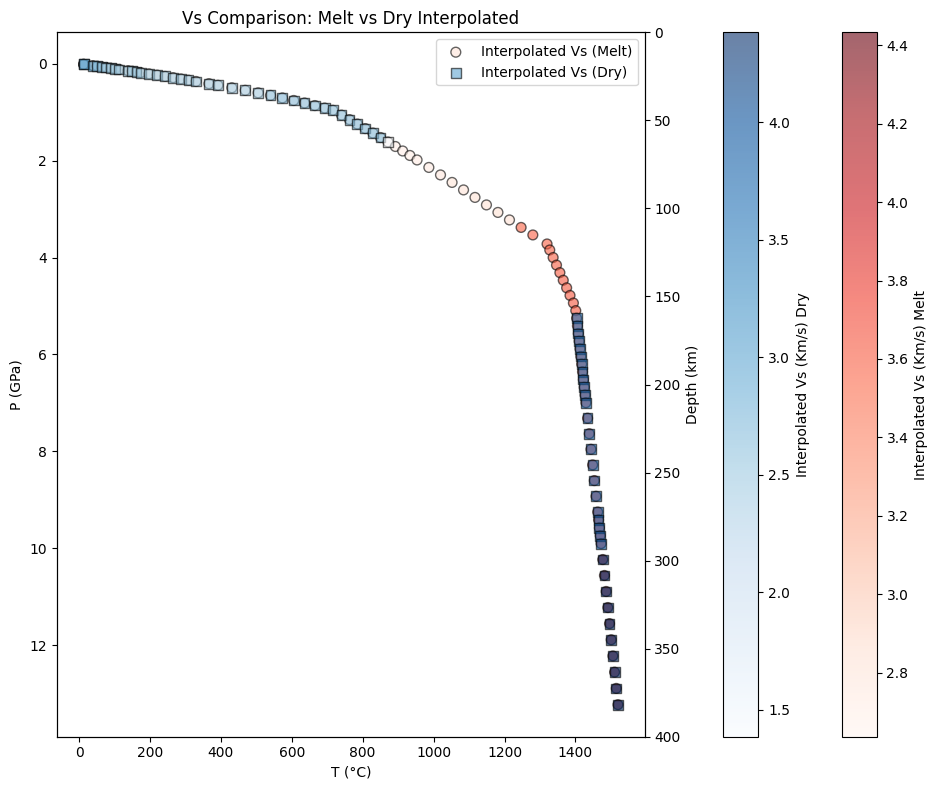

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Function to read data from the Perple_X data file (HP11-melt-CUC.tab and HP11-dry-CUC.tab)
def data_perplex(file_path):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[21:]:
            if not line.startswith('#'):
                parts = line.split()
                if len(parts) >= 7:
                    try:
                        T = float(parts[0]) - 273.15  # Convert K to °C
                        P = float(parts[1]) * 1e-4  # Convert bar to GPa
                        Vs = abs(float(parts[6]))
                        if Vs > 0:
                            data.append((T, P, Vs))
                    except ValueError:
                        continue
    return np.array(data)

# Function to read data from the LitMod2D_2.0_Ref_Model_for_Syn_tomo.dat file
def data_litmod(file_path):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.split()
            if len(parts) >= 8:
                try:
                    Z = float(parts[0])         # Depth (km)
                    Vs = abs(float(parts[3]))   # Shear wave velocity (Vs in km/s)
                    T = float(parts[4])         # Temperature (°C)
                    P = float(parts[5])         # Pressure (Pa)
                    if Vs > 0:
                        data.append((T, P * 1e-9, Vs, Z))  # Convert Pa to GPa
                except ValueError:
                    continue
    return np.array(data)

# Dist-method for interpolation using bilinear interpolation
def dist_method(T1, P1, Vs1, t, p):
    Vs_interpolated = []

    for ti, pi in zip(t, p):
        # Find the surrounding points (T1, P1), (T2, P1), (T1, P2), (T2, P2)
        # Assuming T1 and P1 are sorted arrays of nodal points
        T_lower = T1[T1 <= ti].max()  # T1 (lower T bound)
        T_upper = T1[T1 > ti].min()   # T2 (upper T bound)
        P_lower = P1[P1 <= pi].max()  # P1 (lower P bound)
        P_upper = P1[P1 > pi].min()   # P2 (upper P bound)
        
        # Get corresponding Vs values for each surrounding point
        # Check if there's at least one value before accessing [0]
        if len(Vs1[(T1 == T_lower) & (P1 == P_lower)]) > 0:
            Vs_T1P1 = Vs1[(T1 == T_lower) & (P1 == P_lower)][0]
        else:
            Vs_T1P1 = np.nan  # Handle the case if no valid value is found

        if len(Vs1[(T1 == T_upper) & (P1 == P_lower)]) > 0:
            Vs_T2P1 = Vs1[(T1 == T_upper) & (P1 == P_lower)][0]
        else:
            Vs_T2P1 = np.nan

        if len(Vs1[(T1 == T_lower) & (P1 == P_upper)]) > 0:
            Vs_T1P2 = Vs1[(T1 == T_lower) & (P1 == P_upper)][0]
        else:
            Vs_T1P2 = np.nan

        if len(Vs1[(T1 == T_upper) & (P1 == P_upper)]) > 0:
            Vs_T2P2 = Vs1[(T1 == T_upper) & (P1 == P_upper)][0]
        else:
            Vs_T2P2 = np.nan

        
        # Calculate the differences between adjacent T and P values
        T2_T1 = T_upper - T_lower
        P2_P1 = P_upper - P_lower
        
        # Compute weights for the interpolation point (ti, pi)
        w_T1 = (T_upper - ti) / T2_T1
        w_T2 = (ti - T_lower) / T2_T1
        w_P1 = (P_upper - pi) / P2_P1
        w_P2 = (pi - P_lower) / P2_P1
        
        # Calculate the interpolated Vs
        Vs_interpolated_value = (w_T1 * w_P1 * Vs_T1P1 +  # Weight for Vs at (T1, P1)
                                 w_T2 * w_P1 * Vs_T2P1 +  # Weight for Vs at (T2, P1)
                                 w_T1 * w_P2 * Vs_T1P2 +  # Weight for Vs at (T1, P2)
                                 w_T2 * w_P2 * Vs_T2P2)   # Weight for Vs at (T2, P2)
        
        Vs_interpolated.append(Vs_interpolated_value)

    return np.array(Vs_interpolated)


# Function to write the output data to a .dat file
def write_output_dat(T, P, Z, Vs_litmod, Vs_interpolated_melt, Vs_interpolated_dry, filename):
    with open(filename, 'w') as f:
        f.write("# T(°C)    P(GPa)    Z(km)    Vs_LitMod(Km/s)    Vs_Interpolated_Melt(Km/s)    Vs_Interpolated_Dry(Km/s)    Vs_Difference_Melt(%)    Vs_Difference_Dry(%)\n")
        for t, p, z, vs_litmod, vs_interp_melt, vs_interp_dry in zip(T, P, Z, Vs_litmod, Vs_interpolated_melt, Vs_interpolated_dry):
            vs_diff_melt = 100 * (vs_interp_melt - vs_litmod) / vs_litmod
            vs_diff_dry = 100 * (vs_interp_dry - vs_litmod) / vs_litmod
            f.write(f"{t:.6f}    {p:.6f}    {z:.6f}    {vs_litmod:.6f}    {vs_interp_melt:.6f}    {vs_interp_dry:.6f}    {vs_diff_melt:.6f}    {vs_diff_dry:.6f}\n")

# Plot interpolated Vs values for melt and dry datasets
def plot_vs_comparison(T, P, Vs_interpolated_melt, Vs_interpolated_dry, Z, filename):
    # Create the plot
    fig, ax1 = plt.subplots(figsize=(10, 8))

    # Scatter plot for interpolated melt dataset
    sc1 = ax1.scatter(T, P, c=Vs_interpolated_melt, cmap='Reds', edgecolors='k', s=50, label='Interpolated Vs (Melt)', alpha=0.6)

    # Scatter plot for interpolated dry dataset with a different marker
    sc2 = ax1.scatter(T, P, c=Vs_interpolated_dry, cmap='Blues', edgecolors='k', s=50, marker='s', label='Interpolated Vs (Dry)', alpha=0.6)

    # Add color bars for the interpolated Vs
    cbar1 = plt.colorbar(sc1, ax=ax1, label='Interpolated Vs (Km/s) Melt', pad=0.001)
    cbar2 = plt.colorbar(sc2, ax=ax1, label='Interpolated Vs (Km/s) Dry', pad=0.1)

    # Add labels and title
    ax1.set_title('Vs Comparison: Melt vs Dry Interpolated')
    ax1.set_xlabel('T (°C)')
    ax1.set_ylabel('P (GPa)')
    ax1.invert_yaxis()  # Invert y-axis for pressure

    # Create secondary y-axis for depth
    ax2 = ax1.twinx()
    ax2.set_ylabel('Depth (km)', color='k')
    ax2.set_ylim(Z.max(), Z.min())  # Invert depth axis
    ax2.tick_params(axis='y', labelcolor='k')

    plt.tight_layout()

    # Adding legend manually to ensure it works
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, loc='upper right')

    plt.savefig(filename, format='png')  # Save plot as PNG
    plt.show()


# Load data from files
data_melt = data_perplex('HP11-melt-CUC.tab')
data_dry = data_perplex('HP11-dry-CUC.tab')
data_lit = data_litmod('LitMod2D_2.0_Ref_Model_for_Syn_tomo.dat')

# Extracting data
T_melt, P_melt, Vs_melt = data_melt[:, 0], data_melt[:, 1], data_melt[:, 2]
T_dry, P_dry, Vs_dry = data_dry[:, 0], data_dry[:, 1], data_dry[:, 2]
T_litmod, P_litmod, Vs_litmod, Z_litmod = data_lit[:, 0], data_lit[:, 1], data_lit[:, 2], data_lit[:, 3]

# Perform distance-based interpolation of Vs at the LitMod (T, P) points
Vs_interpolated_melt = dist_method(T_dry, P_dry, Vs_dry, T_litmod, P_litmod) 
Vs_interpolated_dry = dist_method(T_melt, P_melt, Vs_melt, T_litmod, P_litmod) 

# Write the output to .dat file
write_output_dat(T_litmod, P_litmod, Z_litmod, Vs_litmod, Vs_interpolated_melt, Vs_interpolated_dry, 'Interpolated_Vs_All.dat')

# Plot the interpolated Vs values
plot_vs_comparison(T_litmod, P_litmod, Vs_interpolated_melt, Vs_interpolated_dry, Z_litmod, 'Vs_Comparison_Melt_Dry.png')
